In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
easy_data=pd.read_parquet('Data Science Intern - LiDAR Technical Test/lidar_cable_points_easy.parquet')

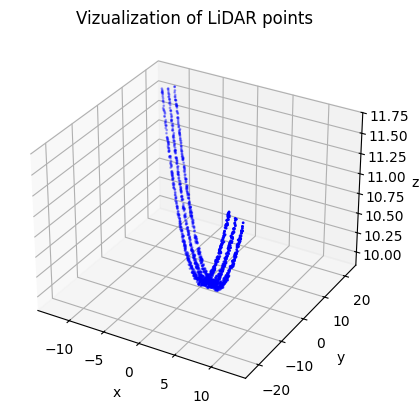

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(easy_data['x'], easy_data['y'], easy_data['z'], s=1, c='blue')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.title("Vizualization of LiDAR points")
plt.show()


/var/folders/1w/qdnlgvv57jsctw3wf6pt0wlr0000gn/T/ipykernel_9014/3508095418.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


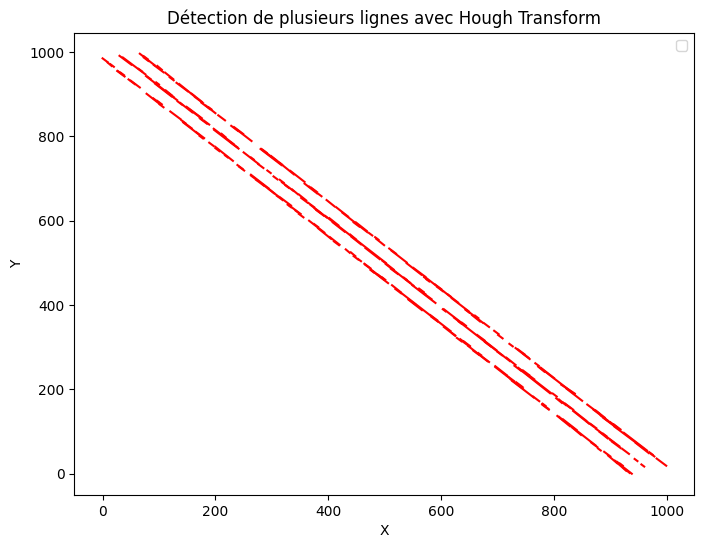

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import probabilistic_hough_line
from skimage.draw import line
from sklearn.cluster import DBSCAN

# Exemple de données projetées (x, y)
points_xy = easy_data[['x', 'y']].values

# Définir les limites de l'image (par exemple, 1000x1000 pixels)
img_size = (1000, 1000)

# Normaliser les coordonnées x, y dans l'espace de l'image
x_min, x_max = points_xy[:, 0].min(), points_xy[:, 0].max()
y_min, y_max = points_xy[:, 1].min(), points_xy[:, 1].max()

# Conversion des coordonnées en indices d'image
x_normalized = np.clip((points_xy[:, 0] - x_min) / (x_max - x_min) * (img_size[1] - 1), 0, img_size[1] - 1)
y_normalized = np.clip((points_xy[:, 1] - y_min) / (y_max - y_min) * (img_size[0] - 1), 0, img_size[0] - 1)
# Création de l'image binaire
edges = np.zeros(img_size, dtype=np.uint8)
edges[y_normalized.astype(int), x_normalized.astype(int)] = 1  # Crée une image binaire pour les points

# Utilisation de la transformée de Hough pour détecter les lignes
lines = probabilistic_hough_line(edges, threshold=10, line_length=5, line_gap=10)

# Visualisation des lignes détectées
plt.figure(figsize=(8, 6))

# Affichage des lignes détectées
for line in lines:
    p0, p1 = line
    plt.plot([p0[0], p1[0]], [p0[1], p1[1]], color='red')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Détection de plusieurs lignes avec Hough Transform')
plt.legend()
plt.show()



In [6]:
def calculate_slope_intercept(p0, p1):
    # Calculer la pente (m) et l'intercept (b) de la droite y = mx + b
    x0, y0 = p0
    x1, y1 = p1
    m = (y1 - y0) / (x1 - x0)  # Pente
    b = y0 - m * x0  # Intercept
    return m, b

In [17]:
from sklearn.cluster import KMeans

# Calcul des pentes et intercepts pour tous les segments
slopes = []
intercepts = []
for p0, p1 in lines:
    m, b = calculate_slope_intercept(p0, p1)
    slopes.append(m)
    intercepts.append(b)

# Conversion des listes en numpy arrays pour le clustering
slopes = np.array(slopes)
intercepts = np.array(intercepts)

# Empiler les pentes et les intercepts dans une matrice pour le clustering
features = np.vstack((slopes, intercepts)).T

# Utiliser KMeans pour forcer 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(features)
labels = kmeans.labels_

# Calcul des équations des droites pour chaque cluster
equations = []
for label in set(labels):
    cluster_indices = np.where(labels == label)[0]
    
    # Récupérer les pentes et intercepts des segments du cluster
    cluster_slopes = slopes[cluster_indices]
    cluster_intercepts = intercepts[cluster_indices]
    
    # Moyenne des pentes et des intercepts du cluster
    avg_slope = np.mean(cluster_slopes)
    avg_intercept = np.mean(cluster_intercepts)
    
    # Equation de la droite pour ce cluster : y = mx + b
    equations.append((avg_slope, avg_intercept))
    
    print(f"Cluster {label + 1}: y = {avg_slope:.2f}x + {avg_intercept:.2f}")


Cluster 1: y = -1.05x + 1058.71
Cluster 2: y = -1.01x + 970.50
Cluster 3: y = -1.02x + 1019.83


Cluster 1: y = -1.82x + 1.50
Cluster 2: y = -1.76x + -1.62
Cluster 3: y = -1.78x + 0.34


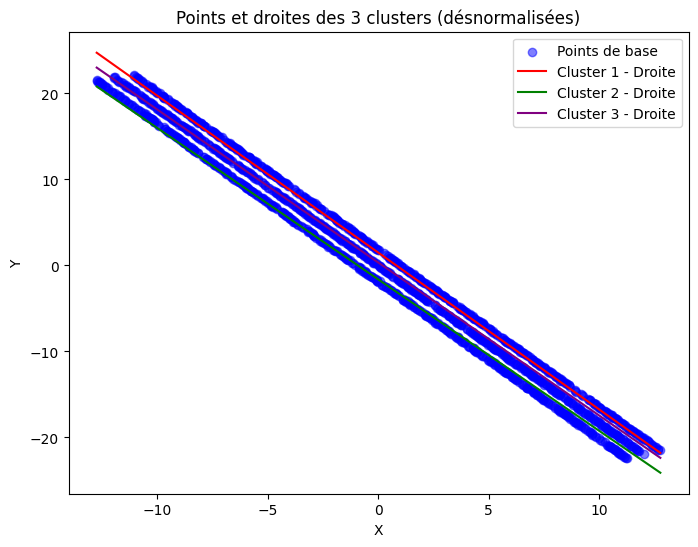

In [18]:
# Recalculer les pentes et intercepts désnormalisés
def denormalize_slope_intercept(slope_norm, intercept_norm, x_min, x_max, y_min, y_max):
    # Calcul des facteurs d'échelle
    scale_x = x_max - x_min  # Facteur d'échelle sur X
    scale_y = y_max - y_min  # Facteur d'échelle sur Y
    
    # Désnormaliser la pente (en multipliant par le facteur d'échelle sur Y / X)
    slope_denorm = slope_norm * scale_y / scale_x
    
    # Désnormaliser l'intercept en prenant en compte le décalage dû à la normalisation des Y
    intercept_denorm = intercept_norm * scale_y/img_size[0] - slope_denorm * x_min +y_min
    
    return slope_denorm, intercept_denorm


# Appliquer la désnormalisation aux pentes et intercepts
denormalized_equations = []
for label in set(labels):
    avg_slope, avg_intercept = equations[label]
    
    # Désnormaliser la pente et l'intercept
    denormalized_slope, denormalized_intercept = denormalize_slope_intercept(avg_slope, avg_intercept, x_min, x_max, y_min, y_max)
    
    denormalized_equations.append((denormalized_slope, denormalized_intercept))
    
    print(f"Cluster {label + 1}: y = {denormalized_slope:.2f}x + {denormalized_intercept:.2f}")

# Visualiser les points et les droites des 3 clusters avec les équations désnormalisées
plt.figure(figsize=(8, 6))

# Affichage des points de base
plt.scatter(points_xy[:, 0], points_xy[:, 1], c='blue', alpha=0.5, label='Points de base')
x_values = np.linspace(easy_data['x'].min(), easy_data['x'].max(), 100)
colors = ['red', 'green', 'purple']
# Tracer la droite pour chaque cluster
for label in set(labels):
    denormalized_slope, denormalized_intercept = denormalized_equations[label]
    y_values = denormalized_slope * x_values + denormalized_intercept  # Calcul des valeurs de y pour cette droite
    plt.plot(x_values, y_values, color=colors[label], label=f'Cluster {label + 1} - Droite')

# Ajouter une légende
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Points et droites des 3 clusters (désnormalisées)')
plt.legend()
plt.show()



In [ ]:
from sklearn.decomposition import PCA

def get_plane_pca(points):
    pca = PCA(n_components=2)
    transformed = pca.fit_transform(points)
    return transformed, pca


In [ ]:
from scipy.optimize import curve_fit
import numpy as np

def catenary(x, y0, c, x0):
    return y0 + c * (np.cosh((x - x0) / c) - 1)

params, _ = curve_fit(catenary, x_2D, y_2D, p0=[np.min(y_2D), 1, np.mean(x_2D)])


In [ ]:
# X_new_2D = np.column_stack((x_2D, catenary(x_2D, *params)))
X_cat_3D = pca.inverse_transform(X_new_2D)
